# Creating shapefile from results in FireStore

In [1]:
from google.cloud import firestore
from pathlib import Path
from shapely.geometry import Point

import contextily as cx
import geopandas
import pandas as pd
import shapefile
import shutil
import sys


sys.path.insert(0,'..')
from street2sat_utils.client import Prediction, calculate_crop_coords

%matplotlib inline

## Initialize database

In [ ]:
# You may need to run the below command to authenticate GCloud 
# !gcloud auth application-default login

In [2]:
db = firestore.Client()
coll = db.collection("street2sat")

## Query data

In [6]:
# Query results from data uploaded by Hannah
query = coll.where("name", ">", "Uganda-2021-06-23").where("name", "<", "Uganda-2021-06-24").get()
num_yolov5_preds = len(query)
print(f"Number of predictions made: {num_yolov5_preds}")

Number of predictions made: 7597


## Parse data items into Prediction objects

In [59]:
crop_preds = []
prediction_images_sample = []
for q in query:
    item = q.to_dict()
    results = item["results"]
    if results != []:
        tags = {
            "time": item["time"],
            "focal_length": item["focal_length"],
            "pixel_height": item["pixel_height"],
            "coord": item["coord"]
        }
        name = item["name"]
        p = Prediction.from_results_and_tags(results, tags, name)
        crop_preds.append(p)
        
    if "labeled_img" in item:
        prediction_images_sample.append(item)

In [10]:
num_crop_preds = len(crop_preds)
print(f"{round(num_crop_preds / num_yolov5_preds, 4)*100}% of the {num_yolov5_preds} yolov5 predictions had crops") 

51.49% of the 7597 yolov5 predictions had crops


## Analyze Images

In [85]:
def get_url(item, multiple_accounts=True):
    host = "https://storage.cloud.google.com/"
    url = item['labeled_img'].replace("gs://", host)
    if multiple_accounts:
        url += "?authuser=1"
    return url

def analyze(item):
    print(f"Prediction: {item['distances']}")
    print(f"See image: {get_url(item)}")

In [86]:
analyze(prediction_images_sample[0])

Prediction: {'maize': 16.36581243763188}
See image: https://storage.cloud.google.com/street2sat-model-predictions/Uganda/2021-06-23_lutoto_left2/100GOPRO/result_G0017668.jpg?authuser=1


## Estimate coordinates of crops

In [11]:
crop_preds = calculate_crop_coords(crop_preds)

## Create dataframe for dataset

In [13]:
def crop_preds_to_df(crop_preds):
    list_of_dicts = []
    for p in crop_preds:
        for crop, new_coord in p.crop_coord.items():
            list_of_dicts.append({
                "crop": crop,
                "lat": new_coord[0],
                "lon": new_coord[1],
                "time": p.time,
                "original_lat": p.coord[0],
                "original_lon": p.coord[1]
            })
    return pd.DataFrame(list_of_dicts)

In [14]:
# Plain dataframe
df = crop_preds_to_df(crop_preds)
df.head()

,crop,lat,lon,time,original_lat,original_lon
0,maize,-0.225822,30.094153,2021-06-23 13:53:42+00:00,-0.225785,30.094011
1,maize,-0.225901,30.094025,2021-06-23 13:53:44+00:00,-0.225901,30.093980
2,maize,-0.226080,30.093908,2021-06-23 13:53:47+00:00,-0.226080,30.093949
3,maize,-0.226108,30.093899,2021-06-23 13:53:47+00:00,-0.226108,30.093947
4,maize,-0.226136,30.093901,2021-06-23 13:53:48+00:00,-0.226136,30.093943


In [43]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat, crs='EPSG:4326'))

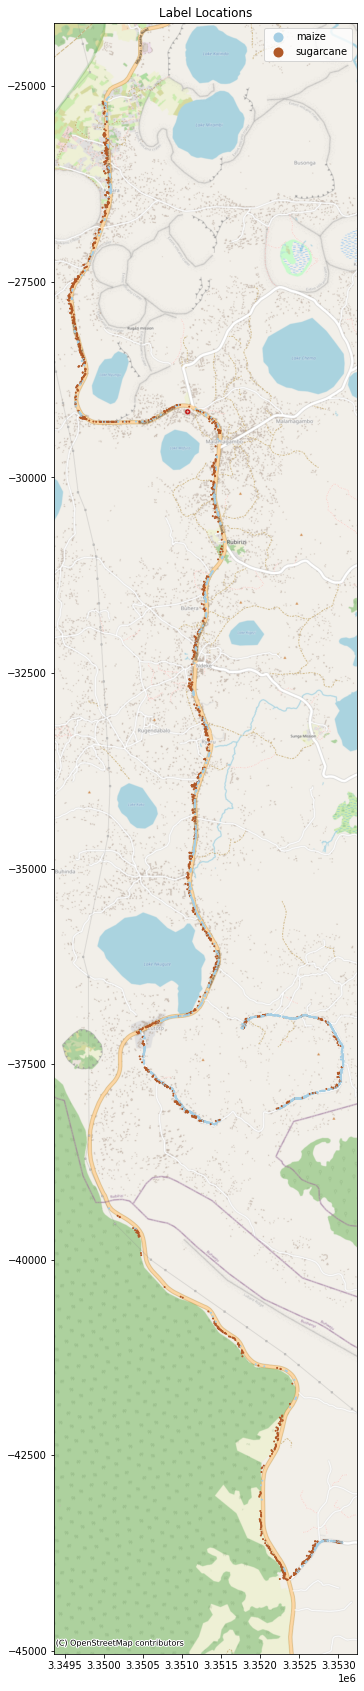

In [57]:
ax = gdf.to_crs('EPSG:3857').plot(
    figsize=(10, 30), 
    marker='o', 
    column='crop', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True
)
ax.set_title("Label Locations")
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

## Create shapefile for dataset

In [112]:
def crop_preds_to_shapefile(crop_preds, dataset_name, target_dir="../temp"):
    dataset_dir = f"{target_dir}/{dataset_name}"
    target = f"{dataset_dir}/{dataset_name}"

    # Create shapefile
    w = shapefile.Writer(target=target, shape=shapefile.POINT)
    w.field("Latitude", "N", decimal=30)
    w.field("Longitude", "N", decimal=30)
    w.field("Crop Type", "C")
    for p in crop_preds:
        for crop, new_coord in p.crop_coord.items():
            w.point(new_coord[1], new_coord[0])
            w.record(new_coord[0], new_coord[1], crop)
    w.close()

    # Create projection file
    prj = open(f"{target}.prj", "w")
    epsg = 'GEOGCS["WGS 84",'
    epsg += 'DATUM["WGS_1984",'
    epsg += 'SPHEROID["WGS 84",6378137,298.257223563]]'
    epsg += ',PRIMEM["Greenwich",0],'
    epsg += 'UNIT["degree",0.0174532925199433]]'
    prj.write(epsg)
    prj.close()

    # Create zipfile
    shutil.make_archive(dataset_dir, 'zip', dataset_dir)
    return dataset_dir

In [115]:
shp_file =  crop_preds_to_shapefile(crop_preds, dataset_name="Uganda-2021-06-23_lutoto")
shp_file

'../temp/Uganda-2021-06-23_lutoto'